# <center><font color='red'>**Time series forecasting: Predicting USA real estate prices**</font></center>


## <center><font color='slategray'>**1. Required libraries**</font></center>

In [1]:
!pip install pmdarima


import numpy as np
import pandas as pd
from pandas import Series

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# For calculation of autocorrelation and partial autocorrelation functions.
from statsmodels.tsa.stattools import acf, pacf
# For displaying autocorrelation.
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import datetime
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.3 MB/s eta 0:00:00


## <center><font color='slategray'>**2. Data analysis and preprocessing**</font></center>

In [3]:
# Reading the data.
raw_data = pd.read_csv('realtor-data.csv')
print(f'Shape of data: {raw_data.shape}\n')
raw_data

Shape of data: (100000, 10)



,status,bed,bath,acre_lot,city,state,zip_code,house_size,prev_sold_date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0
...,...,...,...,...,...,...,...,...,...,...
99995,for_sale,3.0,3.0,NaN,Hudson,Massachusetts,1749.0,2864.0,NaN,749900.0
99996,for_sale,2.0,1.0,0.34,Auburn,Massachusetts,1501.0,1075.0,1999-06-07,349900.0
99997,for_sale,3.0,2.0,1.01,Shrewsbury,Massachusetts,1545.0,1632.0,1995-09-27,549000.0
99998,for_sale,3.0,2.0,0.12,Worcester,Massachusetts,1604.0,1332.0,2000-09-11,299000.0


In [4]:
# Rename a column 'prev_sold_date' to 'Date'.
raw_data.rename({'prev_sold_date': 'Date'}, axis=1, inplace=True)
raw_data

,status,bed,bath,acre_lot,city,state,zip_code,house_size,Date,price
0,for_sale,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,NaN,105000.0
1,for_sale,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,NaN,80000.0
2,for_sale,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,NaN,67000.0
3,for_sale,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,NaN,145000.0
4,for_sale,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,NaN,65000.0
...,...,...,...,...,...,...,...,...,...,...
99995,for_sale,3.0,3.0,NaN,Hudson,Massachusetts,1749.0,2864.0,NaN,749900.0
99996,for_sale,2.0,1.0,0.34,Auburn,Massachusetts,1501.0,1075.0,1999-06-07,349900.0
99997,for_sale,3.0,2.0,1.01,Shrewsbury,Massachusetts,1545.0,1632.0,1995-09-27,549000.0
99998,for_sale,3.0,2.0,0.12,Worcester,Massachusetts,1604.0,1332.0,2000-09-11,299000.0


In [5]:
# Info about the raw data.
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   status      100000 non-null  object 
 1   bed         75050 non-null   float64
 2   bath        75112 non-null   float64
 3   acre_lot    85987 non-null   float64
 4   city        99948 non-null   object 
 5   state       100000 non-null  object 
 6   zip_code    99805 non-null   float64
 7   house_size  75082 non-null   float64
 8   Date        28745 non-null   object 
 9   price       100000 non-null  float64
dtypes: float64(6), object(4)
memory usage: 7.6+ MB


### <center><font color='slategray'>**2.1. Removing columns and missing values**</font></center>

In [6]:
# Rename 'raw_data' into 'removed_data'.

# Removing columns which not need to further analysis.
removed_data = raw_data.drop(['status', 'bed', 	'bath', 'acre_lot',
                              'city', 'state', 'zip_code', 'house_size'],
                             axis=1)
removed_data

,Date,price
0,NaN,105000.0
1,NaN,80000.0
2,NaN,67000.0
3,NaN,145000.0
4,NaN,65000.0
...,...,...
99995,NaN,749900.0
99996,1999-06-07,349900.0
99997,1995-09-27,549000.0
99998,2000-09-11,299000.0


In [7]:
# Checking duplicates in the data.
print('Number of duplicates :', removed_data.duplicated().sum())

Number of duplicates : 93079


In [8]:
# Removing all duplicates in the data.
removed_data.drop_duplicates(inplace=True)

# Checking duplicates after removed.
print('Number of duplicates after removed:', removed_data.duplicated().sum())

Number of duplicates after removed: 0


In [9]:
# Checking a missing data.
print('Columns and missing data:')
removed_data.isnull().sum()

Columns and missing data:


Date     1640
price       0
dtype: int64

In [10]:
# Removing missing values from column 'Date'.
removed_data.dropna(subset=['Date'], inplace=True)
removed_data.isnull().sum()

Date     0
price    0
dtype: int64

In [11]:
# Checking duplicates in the data.
print('Number of duplicates :', removed_data.duplicated().sum())

Number of duplicates : 0


### <center><font color='slategray'>**2.2. Converting the 'Date' column into a datetime format**</font></center>

In [12]:
# By default the "Date" column was in string (object) format,
# we need to convert it into datetime format

# Change the 'Date' column to datetime format.
removed_data.Date = pd.to_datetime(removed_data.Date, format='%Y-%m-%d')

removed_data

,Date,price
684,2020-02-28,76900.0
829,2019-06-28,110000.0
4608,2021-09-15,159000.0
5163,2021-03-15,380000.0
10344,2013-10-11,950000.0
...,...,...
96944,1994-06-28,649900.0
96945,2017-07-07,379900.0
96947,1999-06-29,735000.0
96952,2021-09-23,785000.0


In [13]:
removed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5281 entries, 684 to 97288
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5281 non-null   datetime64[ns]
 1   price   5281 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 123.8 KB


### <center><font color='slategray'>**2.3. Splitting the 'Date' column into a year, a month and a day**</font></center>

In [14]:
# Extract the year, month and day separately.
removed_data['year'] = removed_data.Date.dt.year
removed_data['month'] = removed_data.Date.dt.month
removed_data['day'] = removed_data.Date.dt.day
removed_data

,Date,price,year,month,day
684,2020-02-28,76900.0,2020,2,28
829,2019-06-28,110000.0,2019,6,28
4608,2021-09-15,159000.0,2021,9,15
5163,2021-03-15,380000.0,2021,3,15
10344,2013-10-11,950000.0,2013,10,11
...,...,...,...,...,...
96944,1994-06-28,649900.0,1994,6,28
96945,2017-07-07,379900.0,2017,7,7
96947,1999-06-29,735000.0,1999,6,29
96952,2021-09-23,785000.0,2021,9,23


### <center><font color='slategray'>**2.4. Index definition**</font></center>

In [15]:
# Rename 'removed_data' into 'index_data'.

# Making 'Date' as an index column.
index_data = removed_data.set_index('Date')
print('"Date" is an index now')
print('======================= \n')
index_data

"Date" is an index now



,price,year,month,day
Date,,,,
2020-02-28,76900.0,2020,2,28
2019-06-28,110000.0,2019,6,28
2021-09-15,159000.0,2021,9,15
2021-03-15,380000.0,2021,3,15
2013-10-11,950000.0,2013,10,11
...,...,...,...,...
1994-06-28,649900.0,1994,6,28
2017-07-07,379900.0,2017,7,7
1999-06-29,735000.0,1999,6,29


In [16]:
index_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5281 entries, 2020-02-28 to 1989-08-01
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   5281 non-null   float64
 1   year    5281 non-null   int64  
 2   month   5281 non-null   int64  
 3   day     5281 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 206.3 KB


In [17]:
# Rename 'index_data' into 'main_data'.

# Sorting the 'Date' index column.
main_data = index_data.sort_index()
print(f'Shape of data: {main_data.shape}\n')
main_data

Shape of data: (5281, 4)



,price,year,month,day
Date,,,,
1901-01-01,339000.0,1901,1,1
1910-01-29,269000.0,1910,1,29
1961-09-22,485000.0,1961,9,22
1966-03-09,299900.0,1966,3,9
1966-06-06,353900.0,1966,6,6
...,...,...,...,...
2022-03-04,284900.0,2022,3,4
2022-03-04,309000.0,2022,3,4
2022-03-07,425000.0,2022,3,7


In [18]:
# Main the data info.
main_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5281 entries, 1901-01-01 to 2022-03-23
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   5281 non-null   float64
 1   year    5281 non-null   int64  
 2   month   5281 non-null   int64  
 3   day     5281 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 206.3 KB


<font  size='4'><font color='olive'>For further analysis time-series data I have only 4 columns,   
and index column – 'Date' from 1901-01-01 till 2022-03-23</font>

## <center><font color='slategray'>**3. Data visualisation**</font></center>

                price  year  month  day
Date                                   
1901-01-01   339000.0  1901      1    1
1910-01-29   269000.0  1910      1   29
1961-09-22   485000.0  1961      9   22
1966-03-09   299900.0  1966      3    9
1966-06-06   353900.0  1966      6    6
1966-10-17   850000.0  1966     10   17
1968-01-01   224900.0  1968      1    1
1968-04-01   184900.0  1968      4    1
1968-07-01  3248000.0  1968      7    1
1971-06-23   339900.0  1971      6   23 



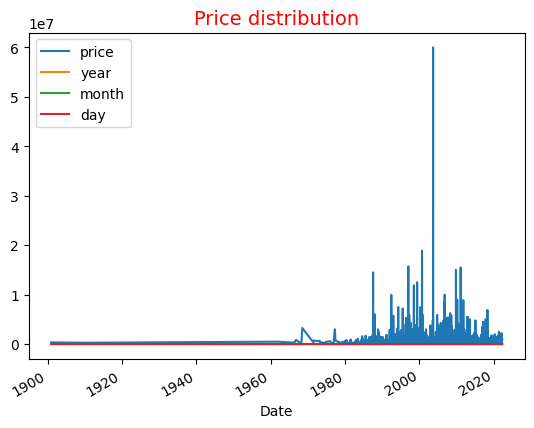

In [19]:
# Get the first 10 rows of the data.
print(main_data.head(10), '\n')

# Display of price distribution.
main_data.plot()
plt.title('Price distribution', size=14, color='r')
plt.show()

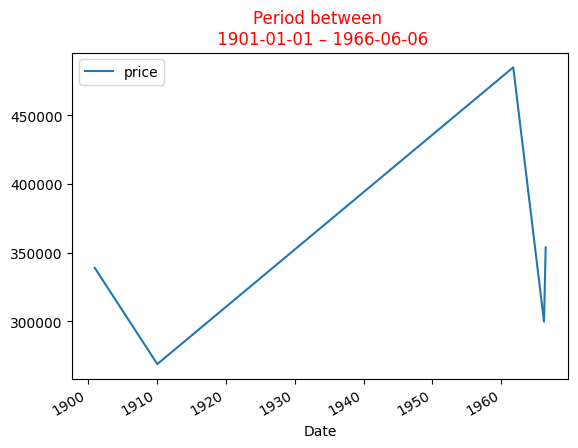

In [20]:
# Displaying of time series price for a certain period.

# Displaying of a certain period.
new_sample_df = main_data.loc['1901-01-01':'1966-06-06', ['price']]
new_sample_df.plot()
plt.title('Period between \n 1901-01-01 – 1966-06-06', size=12, color='r')
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

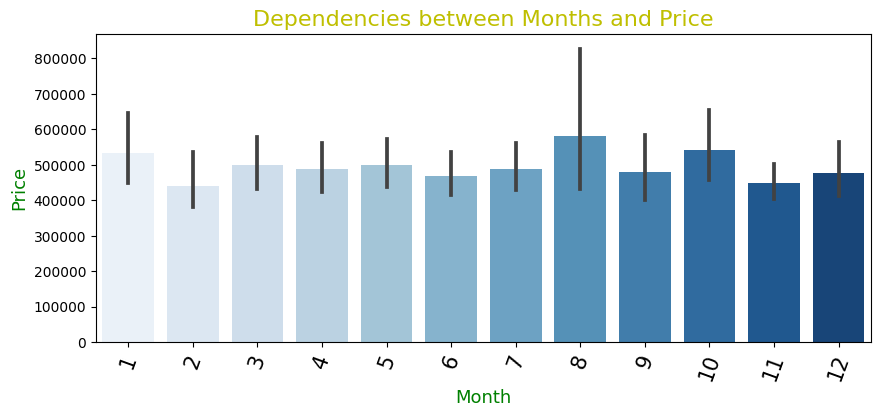

In [21]:
# Displaying of dependencies between months and price.

# Making subplot figure.
plt.figure(figsize=(10, 4))
sns.barplot(data=main_data, x='month', y='price',  palette='Blues')
plt.title('Dependencies between Months and Price', fontsize=16, color='y')
plt.xlabel('Month', fontsize=13, color='g')
plt.ylabel('Price', fontsize=13, color='g')
plt.xticks(rotation=70, fontsize=15)

<font  size='4'><font color='daolive'>How we can see above the most popular month for salling is 8 (August)</font>

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12'),
  Text(12, 0, '13'),
  Text(13, 0, '14'),
  Text(14, 0, '15'),
  Text(15, 0, '16'),
  Text(16, 0, '17'),
  Text(17, 0, '18'),
  Text(18, 0, '19'),
  Text(19, 0, '20'),
  Text(20, 0, '21'),
  Text(21, 0, '22'),
  Text(22, 0, '23'),
  Text(23, 0, '24'),
  Text(24, 0, '25'),
  Text(25, 0, '26'),
  Text(26, 0, '27'),
  Text(27, 0, '28'),
  Text(28, 0, '29'),
  Text(29, 0, '30'),
  Text(30, 0, '31')])

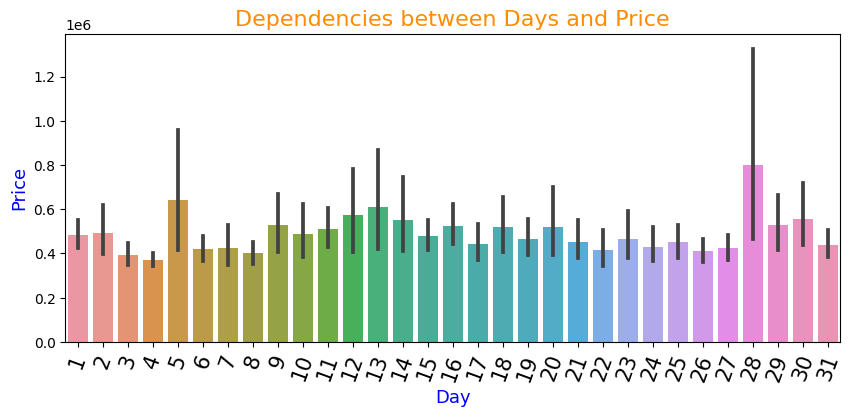

In [22]:
# Displaying of dependencies between days and price.

# Making subplot figure.
plt.figure(figsize=(10, 4))
sns.barplot(data=main_data, x='day', y='price')
plt.title('Dependencies between Days and Price', fontsize=16, color='darkorange')
plt.xlabel('Day', fontsize=13, color='b')
plt.ylabel('Price', fontsize=13, color='b')
plt.xticks(rotation=70, fontsize=15)

<font  size='4'><font color='daolive'>How we can see above the most popular day for salling is 28</font>

### <center><font color='slategray'>**3.1. Resampling and interpolating data**</font></center>

In [23]:
# Resampling the data on yearly frequency.
yearly_resampled_data = main_data.resample('Y').mean()

# Displaying the min price of the each year.
print('--- Yearly frequency ---\n')
print(yearly_resampled_data.to_string())

--- Yearly frequency ---

                   price    year     month        day
Date                                                 
1901-12-31  3.390000e+05  1901.0  1.000000   1.000000
1902-12-31           NaN     NaN       NaN        NaN
1903-12-31           NaN     NaN       NaN        NaN
1904-12-31           NaN     NaN       NaN        NaN
1905-12-31           NaN     NaN       NaN        NaN
1906-12-31           NaN     NaN       NaN        NaN
1907-12-31           NaN     NaN       NaN        NaN
1908-12-31           NaN     NaN       NaN        NaN
1909-12-31           NaN     NaN       NaN        NaN
1910-12-31  2.690000e+05  1910.0  1.000000  29.000000
1911-12-31           NaN     NaN       NaN        NaN
1912-12-31           NaN     NaN       NaN        NaN
1913-12-31           NaN     NaN       NaN        NaN
1914-12-31           NaN     NaN       NaN        NaN
1915-12-31           NaN     NaN       NaN        NaN
1916-12-31           NaN     NaN       NaN        NaN
19

<font  size='4'><font color='blue'>How we can see the dataset has the NaN values.  
For filling them I will use **the interpolate function** with *method='linear'*.  
**The interpolate function** works by drawing a straight line between  
two known data points and estimating the missing values along that line.</font>

In [24]:
# Use interpolate function with method linear to fill the NaN values.
yearly_resampled_data = main_data.resample('Y').mean().interpolate(method='linear')

# Printing the linear interpolated values with average prices.
print('--- Yearly frequency after the interpolate function ---\n')
print(yearly_resampled_data.to_string())

--- Yearly frequency after the interpolate function ---

                   price    year     month        day
Date                                                 
1901-12-31  3.390000e+05  1901.0  1.000000   1.000000
1902-12-31  3.312222e+05  1902.0  1.000000   4.111111
1903-12-31  3.234444e+05  1903.0  1.000000   7.222222
1904-12-31  3.156667e+05  1904.0  1.000000  10.333333
1905-12-31  3.078889e+05  1905.0  1.000000  13.444444
1906-12-31  3.001111e+05  1906.0  1.000000  16.555556
1907-12-31  2.923333e+05  1907.0  1.000000  19.666667
1908-12-31  2.845556e+05  1908.0  1.000000  22.777778
1909-12-31  2.767778e+05  1909.0  1.000000  25.888889
1910-12-31  2.690000e+05  1910.0  1.000000  29.000000
1911-12-31  2.732353e+05  1911.0  1.156863  28.862745
1912-12-31  2.774706e+05  1912.0  1.313725  28.725490
1913-12-31  2.817059e+05  1913.0  1.470588  28.588235
1914-12-31  2.859412e+05  1914.0  1.627451  28.450980
1915-12-31  2.901765e+05  1915.0  1.784314  28.313725
1916-12-31  2.944118e+05 

<font  size='4'><font color='blue'>How we can see now all the NaN values
has been filled.</font>

count    1.220000e+02
mean     4.584178e+05
std      1.798685e+05
min      2.690000e+05
25%      3.420588e+05
50%      4.179321e+05
75%      4.939467e+05
max      1.438000e+06
Name: price, dtype: float64


array([[<Axes: title={'center': 'price'}>,
        <Axes: title={'center': 'year'}>],
       [<Axes: title={'center': 'month'}>,
        <Axes: title={'center': 'day'}>]], dtype=object)

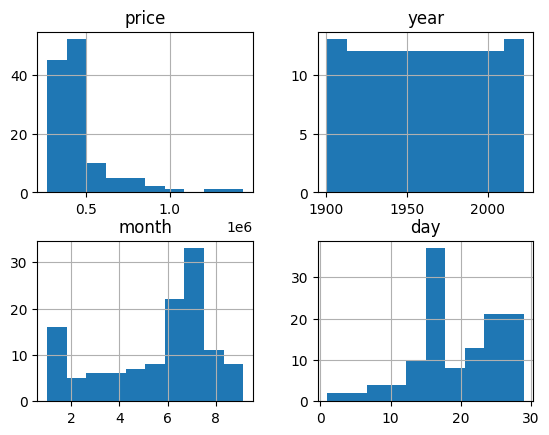

In [25]:
# The basic statistics and characteristics of the data.
get_describe = yearly_resampled_data['price'].describe()
print(get_describe)

# Displaying the histogram.
yearly_resampled_data.hist()

<font  size='4'><font color='blue'>I have got different Skewed Distribution.</font>

In [26]:
# Coefficient of Variation (CV).

# Calculating the ratio of the standard deviation to the mean.
print(f'CV = {get_describe["std"] / get_describe["mean"]:.3f}')

CV = 0.392


In [28]:
# I will use yearly frequency data after resampling and interpolation.

# Period for displaying.
start_date = datetime(1901,12,31)
end_date = datetime(2022,12,31)

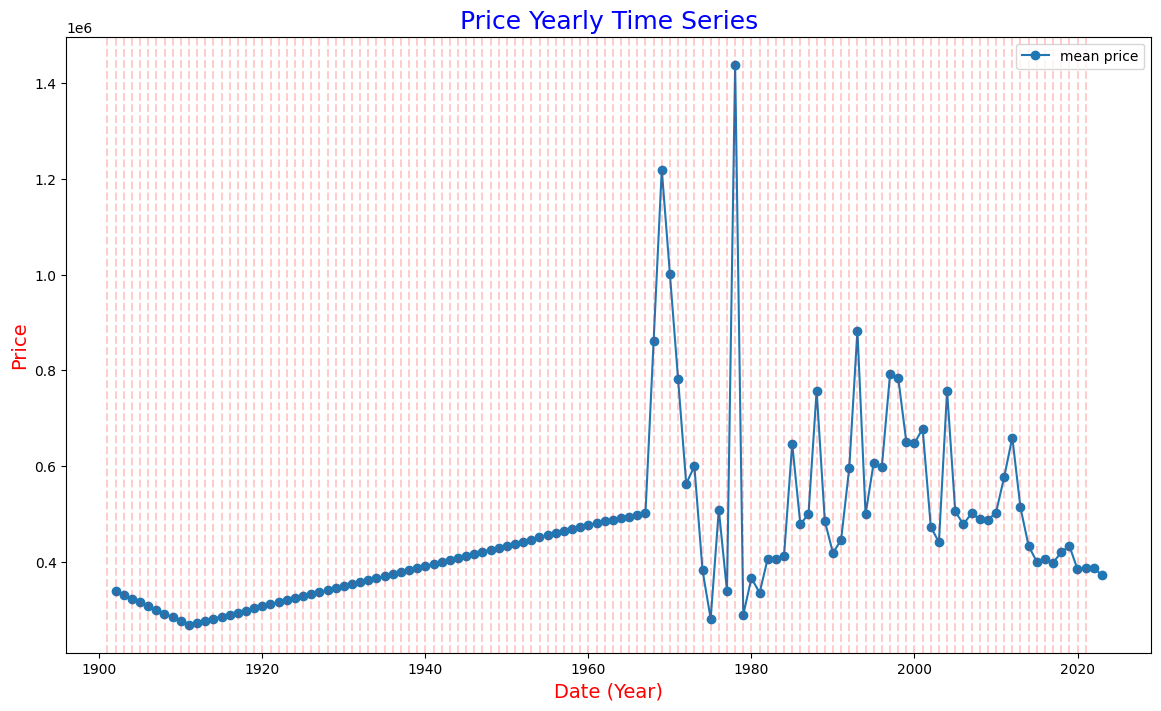

In [29]:
# Plot the yearly price.
plt.figure(figsize=(14,8))

# Making a plot of the figure.
plt.plot(yearly_resampled_data['price'], "o-", label='mean price')
plt.title('Price Yearly Time Series', fontsize=18, color='blue')
plt.xlabel('Date (Year)', fontsize=14, color='red')
plt.ylabel('Price', fontsize=14, color='red')
plt.legend(loc='best')

# Iteration from start to end of all years.
for year in range(start_date.year, end_date.year):
   plt.axvline(pd.to_datetime(str(year)), color='r', linestyle='--', alpha=0.2)

<font  size='4'><font color='blue'>For further analysis, I will reduce number of data from 1990-12-31 till 2022-12-31.</font>

In [30]:
# New period for displaying.
start_date = datetime(1990,12,31)
end_date = datetime(2022,12,31)

# Number of data.
lim_data = yearly_resampled_data[start_date:end_date]
print('Number of rows with data:', len(lim_data))

Number of rows with data: 33


In [31]:
# Dispalaying a table with limited data.
lim_data

,price,year,month,day
Date,,,,
1990-12-31,446117.475000,1990.0,6.100000,16.550000
1991-12-31,596193.305556,1991.0,7.277778,18.194444
1992-12-31,883166.017857,1992.0,7.160714,16.946429
1993-12-31,499403.093750,1993.0,7.234375,16.109375
1994-12-31,607486.450000,1994.0,6.600000,15.683333
1995-12-31,598935.546875,1995.0,6.578125,18.062500
1996-12-31,791418.407895,1996.0,6.986842,17.750000
1997-12-31,784908.333333,1997.0,7.273810,16.250000
1998-12-31,650658.404255,1998.0,7.170213,17.574468


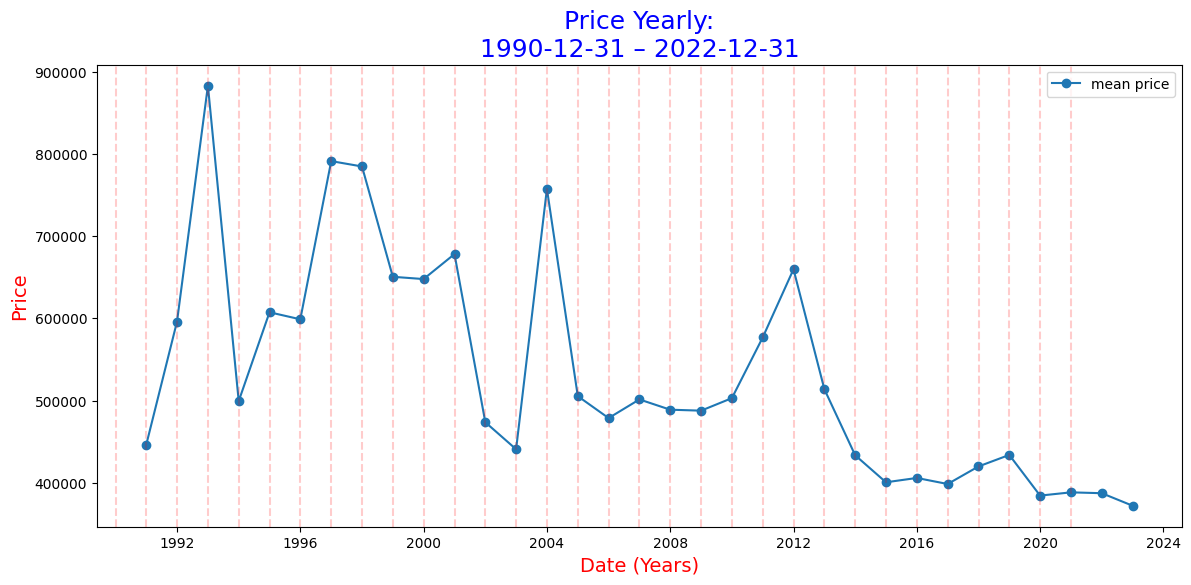

In [32]:
# Plot the yearly price.
plt.figure(figsize=(14,6))

# Making a plot of the figure.
plt.plot(lim_data['price'], "o-", label='mean price')
plt.title('Price Yearly:\n1990-12-31 – 2022-12-31', fontsize=18, color='blue')
plt.xlabel("Date (Years)", fontsize=14, color='red')
plt.ylabel("Price", fontsize=14, color='red')
plt.legend(loc='best')

# Iteration from start to end of all years.
for year in range(start_date.year, end_date.year):
   plt.axvline(pd.to_datetime(str(year)), color='r', linestyle='--', alpha=0.2)


<font  size='4'><font color='blue'>We can see that the time series has a downward trend.</font>

<font  size='3'><font color='green'>Now I will check stationarity or  non-stationarity of the series by:   

1.   Advanced test methodologies like **Dickey Fuller test** as we do below.</font>

## <center><font color='slategray'>**4. **The Dickey-Fuller Test****</font></center>

In [97]:
# Dickey-Fuller Test for original data (lim_date).

# Function to check stationary or non-stationary series.
def check_stationarity(time_series):
    # Perform the Dickey-Fuller Test.
    DF_test = adfuller(time_series, autolag='AIC')
    print('Dickey-Fuller Test:\n')

    print(f'1. ADF: {DF_test[0]:.3f}')
    print(f'2. P-Value: {DF_test[1]:.3f}')
    print(f'3. Num Of Lags: {DF_test[2]:.3f}')
    print('4. Num Of Observations Used For ADF Regression and Critical Values Calculation:', DF_test[3])
    print('5. Critical Values:')

    for key, val in DF_test[4].items():
        print('\t', key, ':', f'{val:.3f}')

    # Determining whether stationary or non-stationary.
    if DF_test[1] > 0.05:
        print('\n\033[1mThe series is non-stationary\033[0m!')
    else:
        print('\n\033[1mThe series is stationary\033[0m!')

# Output result.
check_stationarity(lim_data['price'])

Dickey-Fuller Test:

1. ADF: -0.281
2. P-Value: 0.928
3. Num Of Lags: 10.000
4. Num Of Observations Used For ADF Regression and Critical Values Calculation: 22
5. Critical Values:
	 1% : -3.770
	 5% : -3.005
	 10% : -2.643

The series is non-stationary!


<font  size='4'><font color='blue'>Based on these results, I can conclude the following:   

1. The ADF statistic (-0.281) is greater (less negative and closer to zero) than the 1% critical value (-3.770).   
This indicates that, at the 1% significance level, the ADF statistic is not sufficiently    
negative to support the rejection of the null hypothesis of **non-stationarity**.
2. The p-value (0.928). A high P-value (greater than 0.05) suggests    
that  I do not have enough evidence to reject the null hypothesis of **non-stationarity**.    
In other words, the data does not exhibit strong indications of stationarity.</font>

<font  size='4'><font color='navy'>In the context of the Dickey-Fuller Test for stationarity:


1. **Null Hypothesis** (H0): The time series data is **non-stationary**.
2. **Alternative Hypothesis** (H1): The time series data is **stationary**.  

So, when I have a high P-value (e.g., p > 0.05), it suggests that I do not have enough evidence    
to conclude that the time series is stationary, and I fail to reject the null hypothesis,    
which implies that the data is non-stationary.</font>

<font  size='4'><font color='red'>Therefore, based on ***the Dickey-Fuller Test*** results,    
I have evidence to conclude that the time series data is more likely to be **non-stationarity**.


<font  size='4'><font color='darkred'>**NOTE**: For the following analysis I have to prepare my data as a stationary time series.</font>

## <center><font color='slategray'>**5. Making non-stationary time series to stationary**</font></center>


### <center><font color='slategray'>**5.1. First-Order Differenced Time Series**</font></center>

In [100]:
print('Data before First-Order:\n')
lim_data.price

Data before First-Order:



Date
1990-12-31    446117.475000
1991-12-31    596193.305556
1992-12-31    883166.017857
1993-12-31    499403.093750
1994-12-31    607486.450000
1995-12-31    598935.546875
1996-12-31    791418.407895
1997-12-31    784908.333333
1998-12-31    650658.404255
1999-12-31    647904.000000
2000-12-31    678318.304000
2001-12-31    473675.491935
2002-12-31    440791.604790
2003-12-31    757733.505618
2004-12-31    505410.928889
2005-12-31    478731.000000
2006-12-31    501427.172131
2007-12-31    488936.725581
2008-12-31    487761.619048
2009-12-31    503003.132911
2010-12-31    576795.387387
2011-12-31    659803.505882
2012-12-31    513821.204545
2013-12-31    433467.724138
2014-12-31    400604.725000
2015-12-31    405868.977401
2016-12-31    398511.673077
2017-12-31    419874.344681
2018-12-31    433902.124031
2019-12-31    384410.797203
2020-12-31    388358.516364
2021-12-31    387313.283422
2022-12-31    372084.415385
Freq: A-DEC, Name: price, dtype: float64

In [99]:
'''Rename 'lim_data' to 'first_diff', and transform non-stationary data
into stationary data by subtracting each data point from its previous data point'''

first_diff = lim_data['price'].diff().dropna()

print('Data after First-Order:\n')
first_diff

Data after First-Order:



Date
1991-12-31    150075.830556
1992-12-31    286972.712302
1993-12-31   -383762.924107
1994-12-31    108083.356250
1995-12-31     -8550.903125
1996-12-31    192482.861020
1997-12-31     -6510.074561
1998-12-31   -134249.929078
1999-12-31     -2754.404255
2000-12-31     30414.304000
2001-12-31   -204642.812065
2002-12-31    -32883.887145
2003-12-31    316941.900828
2004-12-31   -252322.576729
2005-12-31    -26679.928889
2006-12-31     22696.172131
2007-12-31    -12490.446550
2008-12-31     -1175.106534
2009-12-31     15241.513864
2010-12-31     73792.254476
2011-12-31     83008.118495
2012-12-31   -145982.301337
2013-12-31    -80353.480408
2014-12-31    -32862.999138
2015-12-31      5264.252401
2016-12-31     -7357.304324
2017-12-31     21362.671604
2018-12-31     14027.779350
2019-12-31    -49491.326828
2020-12-31      3947.719161
2021-12-31     -1045.232941
2022-12-31    -15228.868038
Freq: A-DEC, Name: price, dtype: float64

<font  size='4'><font color='blue'>**The first-order difference** is created by subtracting each data point    
from its previous data point. It helps make the time series more stationary.    
After the differencing technique we can see there are both positive and negative differences,    
suggesting fluctuations. Time series shows the changes in "price" from year to year.</font>

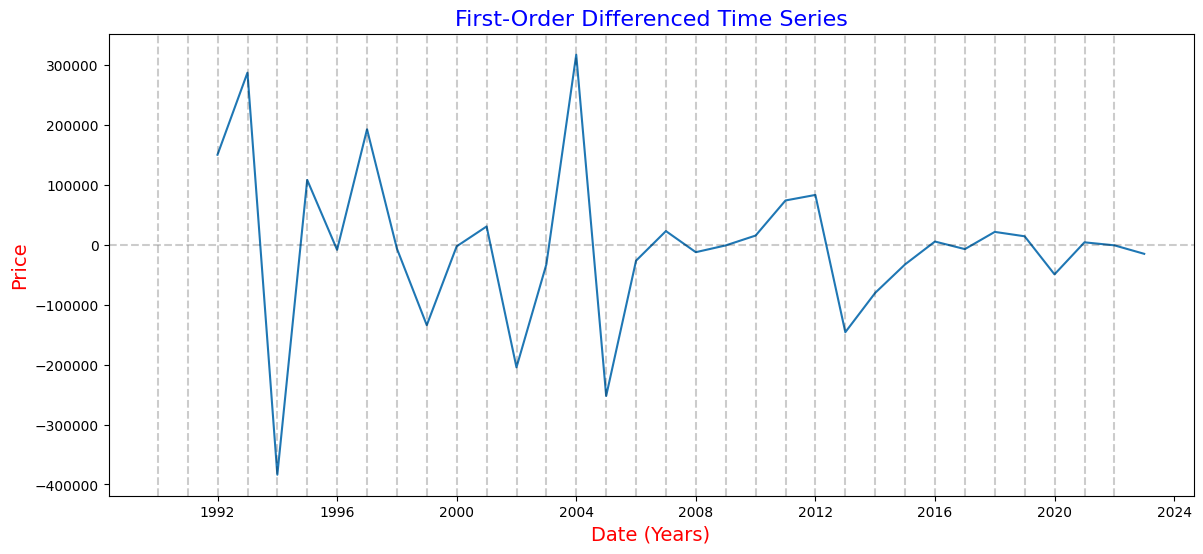

In [94]:
# Displaying First-Order Differenced Time Series.

plt.figure(figsize=(14,6))

plt.plot(first_diff)

plt.title('First-Order Differenced Time Series', fontsize=16, color='blue')
plt.xlabel('Date (Years)', fontsize=14, color='red')
plt.ylabel('Price', fontsize=14, color='red')

for year in range(start_date.year, end_date.year + 1):
   plt.axvline(pd.to_datetime(str(year) + '-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

### <center><font color='slategray'>**5.2. The Dickey Fuller test after First-Order Differenced Time Series**</font></center>

In [96]:
# Dickey-Fuller Test.

# Function to check stationary or non-stationary series.
def check_stationarity(time_series):
    # Perform the Dickey-Fuller Test.
    DF_test = adfuller(time_series, autolag='AIC')
    print('Dickey-Fuller Test:\n')

    print(f'1. ADF: {DF_test[0]:.3f}')
    print(f'2. P-Value: {DF_test[1]:.3f}')
    print(f'3. Num Of Lags: {DF_test[2]:.3f}')
    print('4. Num Of Observations Used For ADF Regression and Critical Values Calculation:', DF_test[3])
    print('5. Critical Values:')

    for key, val in DF_test[4].items():
        print('\t', key, ':', f'{val:.3f}')

    # Determining whether stationary or non-stationary.
    if DF_test[1] > 0.05:
        print('\n\033[1mThe series is non-stationary\033[0m!')
    else:
        print('\n\033[1mThe series is stationary\033[0m!')

# Output result.
check_stationarity(first_diff)

Dickey-Fuller Test:

1. ADF: -2.866
2. P-Value: 0.049
3. Num Of Lags: 9.000
4. Num Of Observations Used For ADF Regression and Critical Values Calculation: 22
5. Critical Values:
	 1% : -3.770
	 5% : -3.005
	 10% : -2.643

The series is stationary!


<font  size='4'><font color='blue'>Based on these results, I can conclude the following:   

1. The ADF value (-2.866) is less than the critical value at the 1% significance level (-3.770).    
This means that at the 1% significance level, you can **reject the null hypothesis**    
that the time series is non-stationary.    
In other words, the ADF statistic falls into the region where the **time series is considered stationary**.
2. The p-value (0.049) is less than the commonly used significance level of 0.05.    
This also supports rejecting the null hypothesis of non-stationarity for the time series.</font>

<font  size='4'><font color='navy'>In the context of the Dickey-Fuller Test for stationarity:


1. **Null Hypothesis** (H0): The time series data is **not stationary**.
2. **Alternative Hypothesis** (H1): The time series data is **stationary**.  

<font  size='4'><font color='red'>Therefore, based on ***the Dickey-Fuller Test*** results,    
I have evidence to conclude that the time series data is more likely to be **stationarity**.

### <center><font color='slategray'>**5.3. Comparison the original and stationary series**</font></center>

Original Series:
Dickey-Fuller Test:

1. ADF: -0.281
2. P-Value: 0.928

The series is non-stationary!

After First-Order Differencing:
Dickey-Fuller Test:

1. ADF: -2.866
2. P-Value: 0.049

The series is stationary!


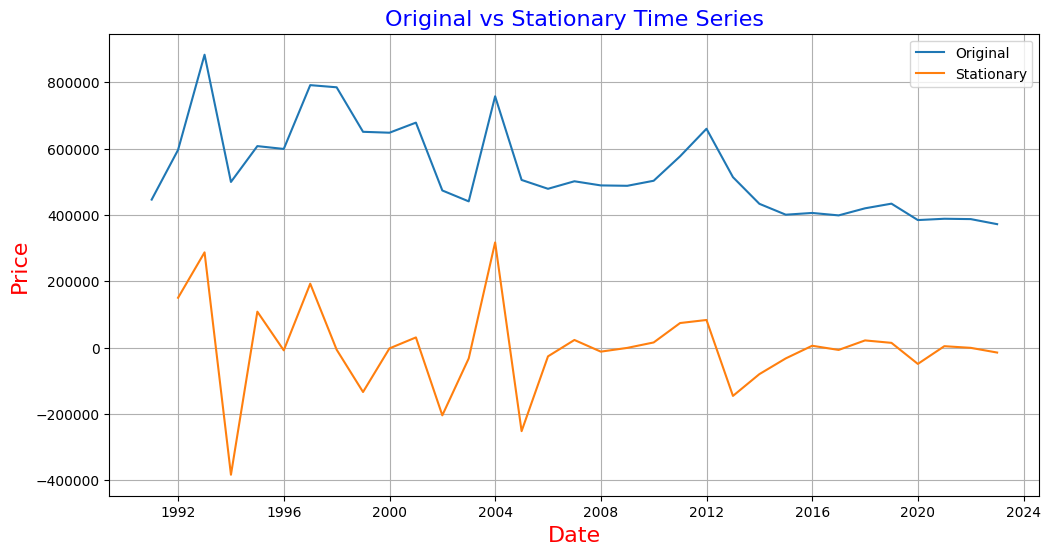

In [105]:
# Function to check stationarity using the Dickey-Fuller Test.
def check_stationarity(time_series):
    # Perform the Dickey-Fuller Test.
    DF_test = adfuller(time_series, autolag='AIC')

    # Print the test results.
    print('Dickey-Fuller Test:\n')
    print(f'1. ADF: {DF_test[0]:.3f}')
    print(f'2. P-Value: {DF_test[1]:.3f}')

    # Determining whether stationary or non-stationary.
    if DF_test[1] > 0.05:
        print('\n\033[1mThe series is non-stationary\033[0m!')
    else:
        print('\n\033[1mThe series is stationary\033[0m!')

# Check stationarity of your data.
print("Original Series:")
check_stationarity(lim_data['price'])

# Apply differencing or other transformations as needed to make it stationary.
# Example: differencing
first_diff = lim_data['price'].diff().dropna()
print("\nAfter First-Order Differencing:")
check_stationarity(first_diff)

# Plot the original and stationary series.
plt.figure(figsize=(12,6))
plt.plot(lim_data.index, lim_data['price'], label='Original')
plt.plot(first_diff.index, first_diff, label='Stationary')
plt.legend()
plt.xlabel('Date', fontsize=16, color='red')
plt.ylabel('Price', fontsize=16, color='red')
plt.title('Original vs Stationary Time Series', fontsize=16, color='blue')
plt.grid(True)
plt.show()

## <center><font color='slategray'>**6. Splitting into trend, seasonality and residuals (noise component), and analyze.**</font></center>

-- The original lim_data --


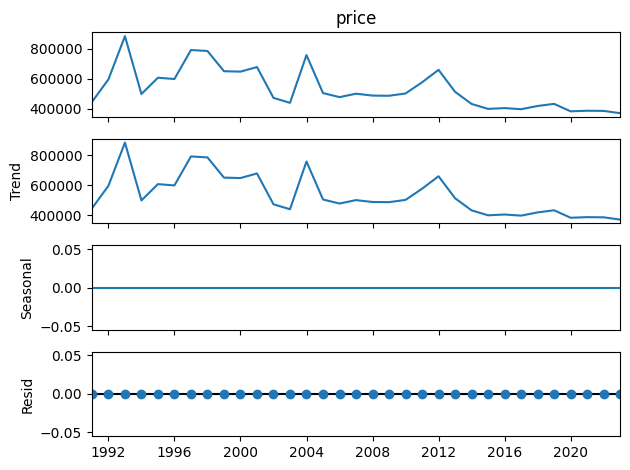

In [ ]:
# Perform seasonal decomposition for original lim_data.
result = sm.tsa.seasonal_decompose(lim_data.price)
print('-- The original lim_data --')
result.plot()
plt.show()

<font  size='4'><font color='blue'>
1.   We can see that **Seasonal** is a straight line.    
It means that data doesn't exhibit a repeating pattern or seasonality over time.    
Also **Seasonality** is not a significant factor in my time series, and the data behaves    
more as a trend with little to no regular seasonal fluctuations.   
2. A straight-line **Residual** component indicates that there is minimal leftover variation    
or noise in the data after accounting for the trend and seasonal components.    
A straight-line residual component is a positive sign.</font>

-- First Diff data --


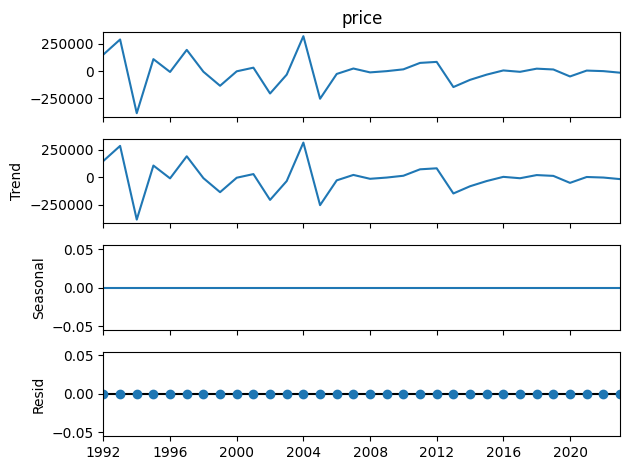

In [ ]:
# Perform seasonal decomposition for First Diff Time Series.
result = sm.tsa.seasonal_decompose(first_diff)
print('-- First Diff data --')
result.plot()
plt.show()

<font  size='4'><font color='red'>We can see that changes occur only in the first two graphs.    
However, it's essential to conduct further analysis of the residuals to ensure    
that there are no significant patterns or autocorrelation left in them.    
For this analysis I will use **autocorrelation function (ACF)**    
and **partial autocorrelation function (PACF)** of the residuals to check for any remaining structure. </font>

## <center><font color='slategray'>**6. ACF and PACF analysis**</font></center>

In [ ]:
# Making Autocorrelation (acf) correlation.
acf_corr = acf(first_diff)
acf_corr

array([ 1.        , -0.32662171, -0.2045233 ,  0.04929831,  0.0719063 ,
       -0.02540649, -0.03588963,  0.04288031,  0.14782986, -0.09301762,
       -0.36769981,  0.34563126, -0.01120997, -0.12199205,  0.07546686,
        0.08200502])

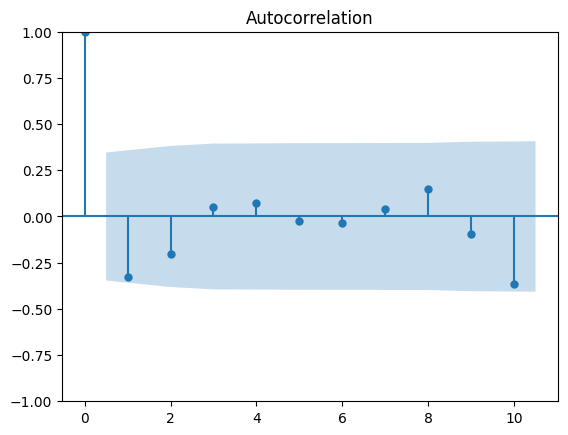

In [ ]:
# Displaying Autocorrelation.
plot_acf(first_diff, lags=10)
plt.show()

<font  size='4'><font color='blue'>**Autocorrelation** measures the linear relationship between a time series and    
its lagged values. In other words, it quantifies how correlated a data point    
is with the data points that are a certain number of time periods behind it.    
*Interpretation*:</font>


<font  size='4'><font color='navy'>
1. Autocorrelation ranges from -1 to 1. **A positive autocorrelation** value (close to indicates    
a positive linear relationship, meaning that as one data point increases,    
the lagged data points also tend to increase.
2. **A negative autocorrelation** value (close to -1) indicates a negative linear relationship,    
meaning that as one data point increases, the lagged data points tend to decrease.
3. A value **close to 0** indicates little to no linear relationship, suggesting that    
there is no consistent pattern of correlation with lagged values.</font>

<font  size='4'><font color='blue'>NOTE: **Autocorrelation** examines how a variable is related to its past values in a time series.</font>

<font  size='3'><font color='red'>Each stick in the plot corresponds to lags starting from 0 (which has the maximum    
correlation of 1 as it is correlation of a time step value with itself ).</font>

In [ ]:
# Making Partial (pacf) correlation.

# nlags=3 - the number of time series intervals.
pacf_corr = pacf(first_diff, nlags=3)
pacf_corr

array([ 1.        , -0.3371579 , -0.37439291, -0.22690695])

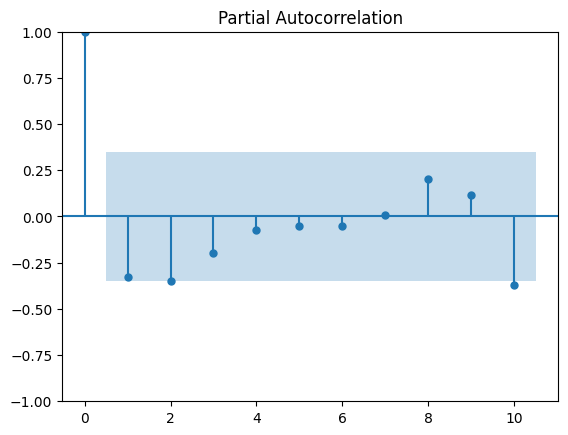

In [ ]:
# Displaying Partial correlation.
plot_pacf(first_diff, lags=10)
plt.show()

<font  size='4'><font color='blue'>**Partial correlation** measures the relationship between two variables while controlling    
for the influence of one or more additional variables. It assesses the direct association    
between two variables after removing the effects of the other variables.    
*Interpretation*:</font>

<font  size='4'><font color='navy'>
1. **A positive partial correlation** indicates that there is a positive linear relationship    
between two variables while controlling for the influence of other variables.     
In other words, when you remove the effects of the controlled variables, there's still    
a positive relationship between the two variables of interest.
2. **A negative partial correlation** indicates a negative linear relationship between    
two variables after accounting for the effects of other variables.
3. A partial correlation **close to 0** suggests that the relationship between    
the two variables of interest is weak once you account for the controlled variables.</font>

<font  size='4'><font color='blue'>NOTE: **partial correlation** examines the relationship between two variables    
while controlling for the influence of other variables.</font>

<font  size='3'><font color='red'>Each stick in the plot corresponds to lags starting from 0 (which has the maximum    
correlation of 1 as it is correlation of a time step value with itself ).</font>

## <center><font color='slategray'>**7. Splitting into Train and Test data**</font></center>

In [ ]:
# Displaying all of my first_diff data to choose a period for training and testing.
print('Number of data points for observation:', len(first_diff), '\n')
print(first_diff)


Number of data points for observation: 32 

Date
1991-12-31    150075.830556
1992-12-31    286972.712302
1993-12-31   -383762.924107
1994-12-31    108083.356250
1995-12-31     -8550.903125
1996-12-31    192482.861020
1997-12-31     -6510.074561
1998-12-31   -134249.929078
1999-12-31     -2754.404255
2000-12-31     30414.304000
2001-12-31   -204642.812065
2002-12-31    -32883.887145
2003-12-31    316941.900828
2004-12-31   -252322.576729
2005-12-31    -26679.928889
2006-12-31     22696.172131
2007-12-31    -12490.446550
2008-12-31     -1175.106534
2009-12-31     15241.513864
2010-12-31     73792.254476
2011-12-31     83008.118495
2012-12-31   -145982.301337
2013-12-31    -80353.480408
2014-12-31    -32862.999138
2015-12-31      5264.252401
2016-12-31     -7357.304324
2017-12-31     21362.671604
2018-12-31     14027.779350
2019-12-31    -49491.326828
2020-12-31      3947.719161
2021-12-31     -1045.232941
2022-12-31    -15228.868038
Freq: A-DEC, Name: price, dtype: float64


In [ ]:
# This date is used as the end point for the training data.
train_end = datetime(2010,12,31)

# This date is used as the end point for the testing data.
test_end = datetime(2022,12,31)

train_data = first_diff[:train_end]
test_data = first_diff[train_end + timedelta(days=1):test_end]

In [ ]:
print('\n Train data:\n', '\n', train_data)
print('Train data points:', len(train_data))

print('\n Test data:\n', '\n', test_data)
print('Test data points:', len(test_data))


 Train data:
 
 Date
1991-12-31    150075.830556
1992-12-31    286972.712302
1993-12-31   -383762.924107
1994-12-31    108083.356250
1995-12-31     -8550.903125
1996-12-31    192482.861020
1997-12-31     -6510.074561
1998-12-31   -134249.929078
1999-12-31     -2754.404255
2000-12-31     30414.304000
2001-12-31   -204642.812065
2002-12-31    -32883.887145
2003-12-31    316941.900828
2004-12-31   -252322.576729
2005-12-31    -26679.928889
2006-12-31     22696.172131
2007-12-31    -12490.446550
2008-12-31     -1175.106534
2009-12-31     15241.513864
2010-12-31     73792.254476
Freq: A-DEC, Name: price, dtype: float64
Train data points: 20

 Test data:
 
 Date
2011-12-31     83008.118495
2012-12-31   -145982.301337
2013-12-31    -80353.480408
2014-12-31    -32862.999138
2015-12-31      5264.252401
2016-12-31     -7357.304324
2017-12-31     21362.671604
2018-12-31     14027.779350
2019-12-31    -49491.326828
2020-12-31      3947.719161
2021-12-31     -1045.232941
2022-12-31    -15228.86803

## <center><font color='slategray'>**8. Holt Winters Algorithm**</font></center>

<font  size='4'><font color='blue'>For applying exponential smoothing to the seasonal components,    
and modeling changes in time series and forecasting future values I will use    
**Holt's Winters** method.</font>   

In [ ]:
# Define the seasonal period as 12 (for yearly seasonality).
seasonal_period = 12

# Perform Holt-Winters forecasting with yearly seasonality.
holt_winter = ExponentialSmoothing(first_diff, seasonal='add',
                                   seasonal_periods=seasonal_period)
hw_fit = holt_winter.fit()
hw_fit
hw_forecast = hw_fit.forecast(len(test_data))

# Summary model table.
hw_fit.summary()


#holt_winter = ExponentialSmoothing(np.asarray(train_data['score']), seasonal_periods=12, trend='add', seasonal='add')


Dep. Variable:,price,No. Observations:,32
Model:,ExponentialSmoothing,SSE,730853896732.354
Optimized:,True,AIC,791.256
Trend:,None,BIC,811.776
Seasonal:,Additive,AICC,827.522
Seasonal Periods:,12,Date:,"Thu, 05 Oct 2023"
Box-Cox:,False,Time:,08:31:26
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.0050000,alpha,True
smoothing_seasonal,0.1658333,gamma,True


In [ ]:
print('The predicted data:\n')
print(hw_forecast)

The predicted data:

2023-12-31     29902.411289
2024-12-31     11686.317687
2025-12-31   -170748.073512
2026-12-31    -13943.925644
2027-12-31    265937.941952
2028-12-31   -134711.227347
2029-12-31    -52613.901880
2030-12-31     40714.227155
2031-12-31     -7302.576808
2032-12-31     29945.884752
2033-12-31      -440.620842
2034-12-31    -86452.552321
Freq: A-DEC, dtype: float64


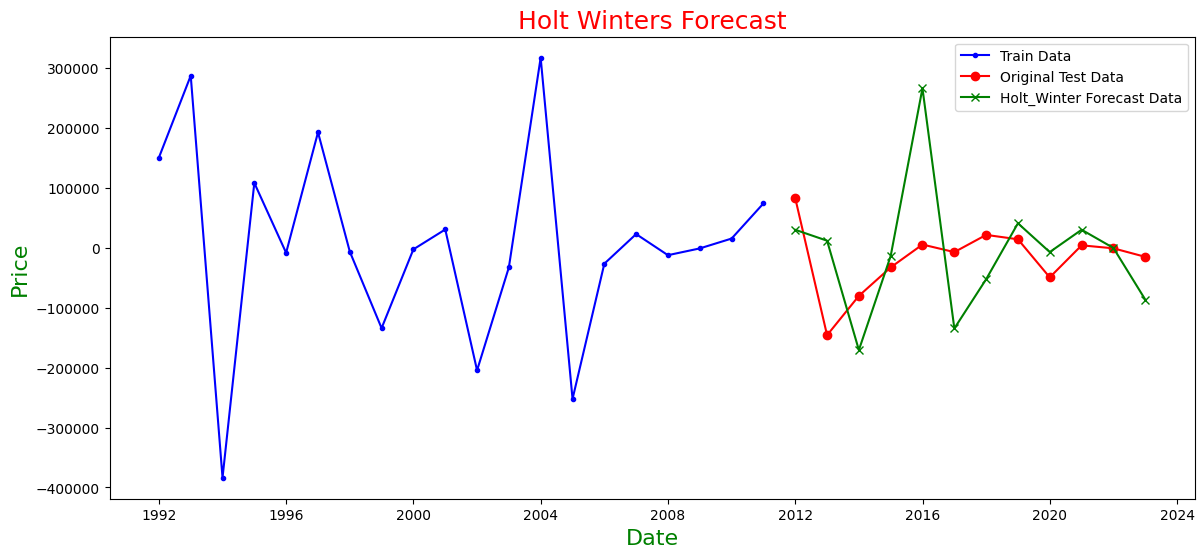

In [ ]:
# # Plot the actual vs forecasted values.
plt.figure(figsize=(14,6))

# Assuming the DataFrame has an integer index.
plt.plot(train_data.index, train_data, "b.-", label='Train Data')  # Assuming the column name is 'price'.
plt.plot(test_data.index, test_data, "ro-", label='Original Test Data')  # Assuming the column name is 'price'.
plt.plot(test_data.index, hw_forecast, "gx-", label='Holt_Winter Forecast Data')
plt.xlabel('Date', fontsize=16, color='green')
plt.ylabel('Price', fontsize=16, color='green')  # Assuming you are forecasting 'price'.
plt.legend(loc='best')
plt.title('Holt Winters Forecast', fontsize=18, color='red')
plt.show()

### <center><font color='slategray'>**8.1. Metrics of Holt Winters Algorithm**</font></center>

In [ ]:
# Holt Winters evaluation.

# Calculate Mean Absolute Error (MAE).
mae = mean_absolute_error(test_data, hw_forecast)

# Calculate Mean Squared Error (MSE).
mse = mean_squared_error(test_data, hw_forecast)

# Calculate Root Mean Squared Error (RMSE).
rmse = np.sqrt(mse)

# Print the metrics.
print('-- Metrics of Holt Winters Algorithm --\n')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')


-- Metrics of Holt Winters Algorithm --

Mean Absolute Error (MAE): 79066.15
Mean Squared Error (MSE): 11174349285.22
Root Mean Squared Error (RMSE): 105708.79


## <center><font color='slategray'>**9. SARIMAX Algorithm**</font></center>

<font  size='4'><font color='blue'>First of all I will find optimal hyperparameters for SARIMAX Algorithm by **auto-arima** function.</font>  
<font  size='4'><font color='blue'>**I have to find**:

1. p - Autoregressive order.
2. d - Integration order.
3. q - Moving average order.
4. P - Seasonal autoregressive order.
5. D - Seasonal integration order.
6. Q - Seasonal moving average order.
7. s - Seasonal period (for monthly data).</font>   

### <center><font color='slategray'>**9.1. Finding the optimum parameters with Auto_arima**</font></center>

In [ ]:
# Searching the best parameters.
auto_arima_model = auto_arima(train_data,
                       start_p=0,
                       start_q=0,
                       max_p=3,
                       max_q=3,
                       m=12,
                       d=1,
                       D=1,
                       test='adf',
                       seasonal=True,
                       trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

# Output the best parameters.
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=202.997, Time=0.70 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=210.696, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.36 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=196.506, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=inf, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=195.510, Time=0.19 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=193.510, Time=0.09 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=195.510, Time=0.28 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=197.510, Time=0.24 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=194.029, Time=0.14 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=204.355, Time=0.13 sec
 ARIMA(1,1,2)(1,1,0)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=202.165, Time=0.23 sec

Best model:  ARIMA(0,1,1)(1,1,0)[12]          
T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   20
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                 -93.755
Date:                             Thu, 05 Oct 2023   AIC                            193.510
Time:                                     08:41:24   BIC                            193.347
Sample:                                 12-31-1991   HQIC                           191.504
                                      - 12-31-2010                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8411      0.833     -1.010      0.313      -2.474       0.792
ar.S.L12      -0.9686      2.188     -0.443      0.658      -5.258       3.320
sigma2      3.901e+10   3.64e-11   1.07e+21      0.000     3.9e+10     3.9e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.75
Prob(Q):                              0.90   Prob(JB):                         0.09
Heteroskedasticity (H):               0.05   Skew:                            -1.82
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.35e+37. Standard errors may be unstable.
"""

<font  size='4'><font color='blue'>According to the above summary it was chosen the next best parameters:
1. **Best model**:  ARIMA(0,1,1)(1,1,0)[12] :

*   p = 0;
*   d = 1;
*   q = 1;
*   P = 1;
*   D = 1;
*   Q = 0;
*   s = 12.
</font>    
<font  size='4'><font color='red'>These parameters I will use for SARIMAX model.</font>  

### <center><font color='slategray'>**9.2. Training SARIMAX model**</font></center>

In [ ]:
# SARIMAX hyperparameters that were chosen by auto-arima.
p = 0
d = 1
q = 1
P = 1
D = 1
Q = 0
s = 12

# Fit the SARIMAX model.
sarimax_model = sm.tsa.SARIMAX(train_data, order=(p, d, q),
                              seasonal_order=(P, D, Q, s))
sarimax_fit = sarimax_model.fit()

# Summary model table.
sarimax_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               price   No. Observations:                   20
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                 -93.755
Date:                             Thu, 05 Oct 2023   AIC                            193.510
Time:                                     08:41:57   BIC                            193.347
Sample:                                 12-31-1991   HQIC                           191.504
                                      - 12-31-2010                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8411      0.833     -1.010      0.313      -2.474       0.792
ar.S.L12      -0.9686      2.188     -0.443      0.658      -5.258       3.320
sigma2      3.901e+10   3.64e-11   1.07e+21      0.000     3.9e+10     3.9e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.75
Prob(Q):                              0.90   Prob(JB):                         0.09
Heteroskedasticity (H):               0.05   Skew:                            -1.82
Prob(H) (two-sided):                  0.09   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.35e+37. Standard errors may be unstable.
"""

In [ ]:
# Get prediction and residuals.
sarimax_prediction = sarimax_fit.forecast(len(test_data))
sarimax_prediction = pd.Series(sarimax_prediction, index=test_data.index)
residuals = test_data - sarimax_prediction

In [ ]:
# Differences between the actual values (test_data)
# and predicted values (sarimax_prediction).

print('The residuals data:\n')
residuals

The residuals data:



Date
2011-12-31     68706.759672
2012-12-31   -161324.808943
2013-12-31    -88315.912216
2014-12-31    -46217.988658
2015-12-31   -164437.913976
2016-12-31   -291785.895235
2017-12-31    379527.259099
2018-12-31   -105762.235569
2019-12-31    -55204.191182
2020-12-31   -196842.559349
2021-12-31     -9605.517910
2022-12-31     98101.970743
Freq: A-DEC, dtype: float64

Text(0, 0.5, 'Error')

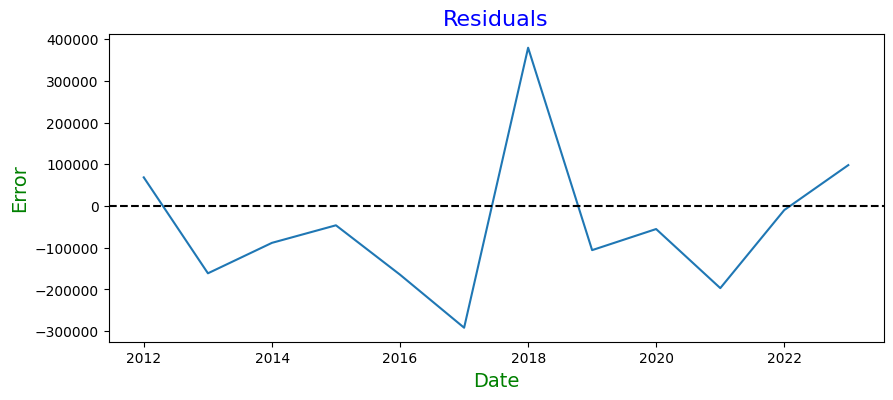

In [ ]:
# Displaying residuals.
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals', fontsize=16, color='blue')
plt.xlabel('Date', fontsize=14, color='green')
plt.ylabel('Error', fontsize=14, color='green')

In [ ]:
print('-- Residuals mean --\n')
residuals.mean()

-- Residuals mean --



-47763.4194604166

In [ ]:
print('The predicted data by SARIMAX:\n')
sarimax_prediction

The predicted data by SARIMAX:



Date
2011-12-31     14301.358823
2012-12-31     15342.507606
2013-12-31      7962.431809
2014-12-31     13354.989520
2015-12-31    169702.166377
2016-12-31    284428.590911
2017-12-31   -358164.587495
2018-12-31    119790.014919
2019-12-31      5712.864354
2020-12-31    200790.278510
2021-12-31      8560.284969
2022-12-31   -113330.838781
Freq: A-DEC, Name: predicted_mean, dtype: float64

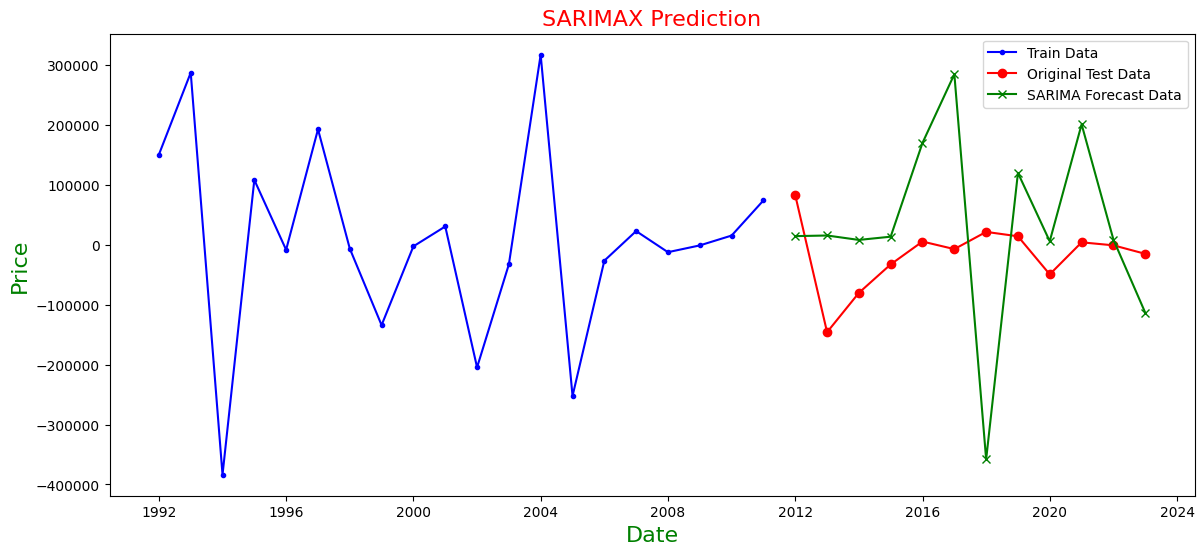

In [ ]:
# Plot the actual vs predicted values.
plt.figure(figsize=(14,6))
plt.plot(train_data.index, train_data, 'b.-', label='Train Data') # Assuming the column name is 'price'.
plt.plot(test_data.index, test_data, 'ro-', label='Original Test Data') # Assuming the column name is 'price'.
plt.plot(test_data.index, sarimax_prediction, 'gx-', label='SARIMA Forecast Data')
plt.xlabel('Date', fontsize=16, color='green')
plt.ylabel('Price', fontsize=16, color='green')
plt.title('SARIMAX Prediction', fontsize=16, color='red')

plt.legend()
plt.show()

In [ ]:
print('-- SARIMAX prediction mean --\n')
sarimax_prediction.mean()

-- SARIMAX prediction mean --



30704.171793518926

### <center><font color='slategray'>**9.3. Metrics of SARIMAX model**</font></center>

In [ ]:
# SARAIMAX evaluation.
mae = mean_absolute_error(test_data, sarimax_prediction)
mse = mean_squared_error(test_data, sarimax_prediction)
rmse = np.sqrt(mse)

# Print the metrics.
print('-- Metrics of SARIMAX model --\n')
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


-- Metrics of SARIMAX model --

Mean Absolute Error (MAE): 138819.42
Mean Squared Error (MSE): 29966525103.92
Root Mean Squared Error (RMSE): 173108.42


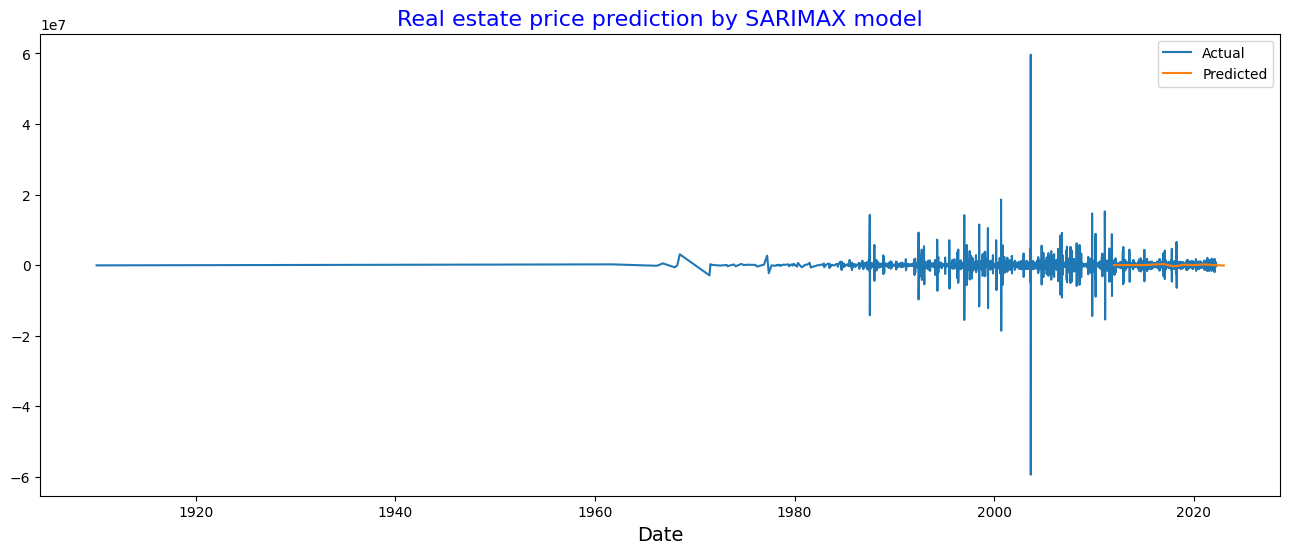

In [ ]:
# SARIMAX Prediction.
plt.figure(figsize=(16,6))
plt.plot(main_data['price'].diff(), label='Actual')
plt.plot(sarimax_prediction, label='Predicted')
plt.title('Real estate price prediction by SARIMAX model', fontsize=16, color='blue')
plt.xlabel('Date', fontsize=14)
plt.legend()